In [ ]:
buifrom google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D, AveragePooling1D, Dropout
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, BatchNormalization, Softmax
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model Subclassing

In [ ]:
class MyModel(Model): # subclass from functional API (Model)
  def __init__(self, num_classes, **kwargs): # must create layers in initializer
    super(MyModel, self).__init__(**kwargs) # this calls the initializer for the base class
    self.dense1 = Dense(16, activation='sigmoid')
    self.dropout = Dropout(0.5)
    self.dense2 = Dense(num_classes, activation='softmax')
  
  def call(self, inputs, training=False): # must define forward pass in call method
    h = self.dense1(inputs)
    h = self.dropout(h, training=training) # can use training kwarg to determine model behavior at training and testing time 
    # ^ common in dropout and batchnormalization
    # ^ during training, it zeros out some weights and automatically scales up remaining activations (does nothing at test time) 
    return self.dense2(h)

my_model = MyModel(10, name='my_model') # name argument is called down to base class constructor

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = Dense(64, activation='relu')
    self.dense2 = Dense(10)
    self.dense3 = Dense(5)
    self.softmax = Softmax()
    

  def call(self, inputs):
    # create non-linear topology (inputs fed into two branches that get concatenated)
    x = self.dense1(inputs)
    y1 = self.dense2(inputs)
    y2 = self.dense3(y1)
    concat = concatenate([x, y2])
    return self.softmax(concat)

In [ ]:
model = MyModel()
model(tf.random.uniform([1,10])) # apply random input to initialize weights to be able to display summary (since we didn't specify input dims)
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  704       
_________________________________________________________________
dense_13 (Dense)             multiple                  110       
_________________________________________________________________
dense_14 (Dense)             multiple                  55        
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


## Custom Layers

In [ ]:
from tensorflow.keras.layers import Layer

class LinearMap(Layer):
  def __init__(self, input_dim, units): # create layer variables in initializer
    super(LinearMap, self).__init__()
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units)))
    # alternatively:
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal') # can use add_weight method

  def call(self, inputs): # create layer computation
    return tf.matmul(inputs, self.w)

linear_layer = LinearMap(3,2)
inputs = tf.ones((1,3))
print(linear_layer(inputs))

tf.Tensor([[0.12671944 0.09986061]], shape=(1, 2), dtype=float32)


In [ ]:
print(linear_layer.weights)

[<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.09473039, -0.00596663],
       [ 0.02903558, -0.01951596],
       [ 0.00295347,  0.12534319]], dtype=float32)>]


In [ ]:
# use custom layer in custom model
class MyModel(Model):
  def __init__(self, hidden_units, outputs, **kwargs):
    super(MyModel, self).__init__(**kwargs)
    self.dense = Dense(hidden_units, activation='sigmoid')
    self.linear = LinearMap(hidden_units, outputs)
  
  def call(self, inputs):
    h = self.dense(inputs)
    return self.linear(h)

my_model = MyModel(64, 12, name='my_custom_model')

In [ ]:
class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))
print(dense_layer(x))

tf.Tensor([[0.068652   0.07478131 0.2249854 ]], shape=(1, 3), dtype=float32)


In [ ]:
print(dense_layer.weights)

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.01011528,  0.00958445,  0.04626101],
       [-0.00246293, -0.02039954,  0.00590516],
       [ 0.08016944,  0.00608544,  0.11644899],
       [-0.02036155,  0.01648335,  0.00442636],
       [ 0.00119178,  0.06302759,  0.0519439 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [ ]:
class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False) # can freeze weights with trainable=False
    self.b = self.add_weight(shape=(units), initializer='zeros', trainable=False)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [ ]:
print('Trainable: ', len(dense_layer.trainable_weights))
print('Non-Trainable: ', len(dense_layer.non_trainable_weights))

Trainable:  0
Non-Trainable:  2


In [ ]:
class MyLayerMean(Layer): # create a custom layer that returns the mean of the outputs when it is called
  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units), initializer='zeros')
    self.sum_activation = tf.Variable(initial_value = tf.zeros(units), trainable=False)
    self.number_call = tf.Variable(initial_value = 0, trainable=False)

  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
    self.number_call.assign_add(inputs.shape[0])
    return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3,5)

In [ ]:
y, activation_means = dense_layer(tf.ones((1,5)))
print(activation_means.numpy())

[-0.11764914  0.20847748  0.04283962]


In [ ]:
class MyDropout(Layer):
  def __init__(self, rate):
    super(MyDropout, self).__init__()
    self.rate = rate

  def call(self, inputs):
    return Dropout(self.rate)(inputs)

In [ ]:
class MyModel(Model):
  def __init__(self, units1, input_dim1, units2, units3):
    super(MyModel, self).__init__()
    self.layer1 = MyLayer(units1, input_dim1)
    self.dropout1 = MyDropout(0.5)
    self.layer2 = MyLayer(units2, units1)
    self.dropout2 = MyDropout(0.5)
    self.layer3 = MyLayer(units3, units2)
    self.softmax = Softmax()

  def call(self, inputs):
    x = self.layer1(inputs)
    x = tf.nn.relu(x)
    x = self.dropout1(x)
    x = self.layer2(x)
    x = tf.nn.relu(x)
    x = self.dropout2(x)
    x = self.layer3(x)
    x = self.softmax(x)
    return x
model = MyModel(64, 10000, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.01784968 0.03116669 0.02418305 0.01943855 0.01433028 0.02021854
  0.01894048 0.01852905 0.01997964 0.01264232 0.03143034 0.02317801
  0.01944386 0.00981589 0.00997502 0.02716385 0.01719619 0.01597964
  0.02012455 0.0417648  0.03540619 0.01073792 0.02024842 0.01969167
  0.03535643 0.01792374 0.01898918 0.03441435 0.01595461 0.01141197
  0.01471403 0.01247098 0.01843815 0.03496267 0.03534813 0.02834598
  0.01670852 0.02743335 0.01963033 0.02350542 0.01095335 0.02574417
  0.01691446 0.01597175 0.03030899 0.03506493]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_4 (MyLaye

## Build method - allows you to delay specifying the input dimensions
- particularly useful when using the same layer multiple times within a model, which would make it difficult/annoying to keep track of input into each layer 

In [ ]:
class MyLayer(Layer):
  def __init__(self, units, **kwargs):
    super(MyLayer, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal')
    self.b = self.add_weight(shape=(self.units), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3) # no longer need to specify input_shape

In [ ]:
# can now use the layer on an input and it will internally use the build method to initialize the weights/biases
print(dense_layer(tf.ones((1,5))))

tf.Tensor([[-0.09803927 -0.0396199  -0.13723053]], shape=(1, 3), dtype=float32)


In [ ]:
dense_layer.weights

[<tf.Variable 'my_layer_6/Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[-0.0347124 , -0.06217093, -0.00272919],
        [-0.04671925,  0.02261365, -0.07082822],
        [ 0.0113139 , -0.01738444,  0.03486134],
        [ 0.04783482,  0.04910361, -0.09439021],
        [-0.07575634, -0.03178179, -0.00414425]], dtype=float32)>,
 <tf.Variable 'my_layer_6/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [ ]:
dense_layer = MyLayer(3)
print(dense_layer(tf.ones((1,4)))) # can do it again using input with different shape

tf.Tensor([[ 0.01578     0.00097658 -0.03959544]], shape=(1, 3), dtype=float32)


In [ ]:
dense_layer.weights

[<tf.Variable 'my_layer_7/Variable:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.00916119, -0.04089218, -0.01198277],
        [-0.05842384,  0.02656902, -0.03560404],
        [ 0.05654021,  0.02132601,  0.00348857],
        [ 0.00850244, -0.00602627,  0.0045028 ]], dtype=float32)>,
 <tf.Variable 'my_layer_7/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

## Automatic differentiation

In [ ]:
x = tf.constant([0,1,2,3], dtype=tf.float32)
with tf.GradientTape() as tape:
  tape.watch(x) # any operations performed on x will be recorded (as if on tape) (also records intermediate steps that use x)
  # ^ note that tape.watch is not necessary for computations done using tf functions since they are automatically 'watched'
  y = tf.reduce_sum(x**2)
  z = tf.math.sin(y)
  dz_dy, dz_dx = tape.gradient(z, [y,x]) # derivative of z wrt y and x
print(dz_dy, dz_dx)

tf.Tensor(0.13673721, shape=(), dtype=float32) tf.Tensor([0.         0.27347443 0.54694885 0.82042325], shape=(4,), dtype=float32)


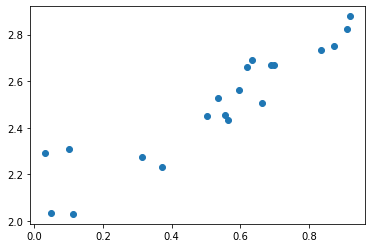

In [ ]:
def MakeNoisyData(m, b, n=20):
  x = tf.random.uniform(shape=(n,))
  noise = tf.random.normal(shape=(n,), stddev=0.1)
  y = m*x + b + noise
  return x, y

X_train, y_train = MakeNoisyData(1, 2)
plt.scatter(X_train, y_train)

In [ ]:
class LinearLayer(Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape=(1,), initializer='random_normal')
    self.b = self.add_weight(shape=(1,), initializer='zeros')

  def call(self, inputs):
    return self.m * inputs + self.b

linear_regression = LinearLayer()
print(linear_regression(X_train))
print(linear_regression.weights)

tf.Tensor(
[0.01111575 0.00062157 0.00142253 0.00129454 0.00040936 0.00875955
 0.00842152 0.00471917 0.01062533 0.01159043 0.00681174 0.00397142
 0.00786354 0.00706771 0.00886208 0.00806063 0.00717127 0.00757564
 0.01168235 0.00637574], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.01271441], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [ ]:
# define loss function
def SquaredError(y_pred, y_true):
  return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(X_train), y_train)
print('Starting Loss: ', starting_loss)

Starting Loss:  tf.Tensor(6.26842, shape=(), dtype=float32)


In [ ]:
# Implement gradient descent training loop
learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(X_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate*gradients[0])
  linear_regression.b.assign_sub(learning_rate*gradients[1])

  print('Step {}, Loss {}'.format(i, loss.numpy()))

Step 0, Loss 6.268420219421387
Step 1, Loss 4.751451015472412
Step 2, Loss 3.602389097213745
Step 3, Loss 2.7320034503936768
Step 4, Loss 2.0727033615112305
Step 5, Loss 1.5732934474945068
Step 6, Loss 1.194994330406189
Step 7, Loss 0.9084318280220032
Step 8, Loss 0.6913563013076782
Step 9, Loss 0.5269148945808411
Step 10, Loss 0.40234166383743286
Step 11, Loss 0.30796733498573303
Step 12, Loss 0.23646774888038635
Step 13, Loss 0.182295024394989
Step 14, Loss 0.14124688506126404
Step 15, Loss 0.11014024913311005
Step 16, Loss 0.08656411617994308
Step 17, Loss 0.06869218498468399
Step 18, Loss 0.05514112859964371
Step 19, Loss 0.044863127171993256
Step 20, Loss 0.03706452250480652
Step 21, Loss 0.03114408254623413
Step 22, Loss 0.026646455749869347
Step 23, Loss 0.023226702585816383
Step 24, Loss 0.020623549818992615


original m: 1, trained m: [1.0158209]
original b: 2, trained b: [1.8771893]


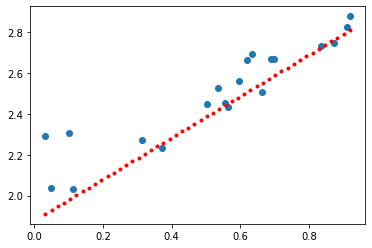

In [ ]:
print('original m: {}, trained m: {}'.format(1, linear_regression.m.numpy()))
print('original b: {}, trained b: {}'.format(2, linear_regression.b.numpy()))

plt.scatter(X_train, y_train)
x_linear_regression = np.linspace(min(X_train), max(X_train), 50)
plt.plot(x_linear_regression, linear_regression.m * x_linear_regression + linear_regression.b, 'r.')

In [ ]:
class MyLayer(Layer):
  def __init__(self, units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', name='kernel')
    self.b = self.add_weight(shape=(self.units), initializer='zeros', name='bias')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):
  def __init__(self, rate):
    super(MyDropout, self).__init__()
    self.rate = rate

  def call(self, inputs):
    return Dropout(self.rate)(inputs)

class MyModel(Model):
  def __init__(self, units1, units2, units3):
    super(MyModel, self).__init__()
    self.layer1 = MyLayer(units1)
    self.dropout1 = MyDropout(0.5)
    self.layer2 = MyLayer(units2)
    self.dropout2 = MyDropout(0.5)
    self.layer3 = MyLayer(units3)
    self.softmax = Softmax()

  def call(self, inputs):
    x = self.layer1(inputs)
    x = tf.nn.relu(x)
    x = self.dropout1(x)
    x = self.layer2(x)
    x = tf.nn.relu(x)
    x = self.dropout2(x)
    x = self.layer3(x)
    x = self.softmax(x)
    return x

In [ ]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.01250535 0.01826994 0.02024769 0.02413729 0.01200693 0.02790804
  0.0254126  0.01040631 0.01751738 0.0198219  0.02250949 0.04366915
  0.02448612 0.01331524 0.02018389 0.01193312 0.02280809 0.03905114
  0.01880191 0.03018289 0.01143811 0.02061883 0.00788181 0.01439214
  0.02406374 0.02938599 0.02753192 0.03680399 0.02860622 0.01730116
  0.00863912 0.04975107 0.01730953 0.01309278 0.02876136 0.01736529
  0.02169166 0.01282033 0.01034453 0.01826675 0.02302082 0.01257225
  0.03630637 0.01890709 0.0224006  0.03555203]], shape=(1, 46), dtype=float32)
Model: "my_model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_23 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_12 (MyDropout)    multiple                  0         
_________________________________________________________________
my_layer_24 (MyLa

In [ ]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print('Label: ', class_names[train_labels[0]])

Label:  earn


In [ ]:
word_to_index = reuters.get_word_index()
index_to_word = {value:key for key,value in word_to_index.items()}
text_news = ' '.join(index_to_word.get(i-3, '?') for i in train_data[0])
text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [ ]:
def bag_of_words(text_samples, elements=10000):
  output = np.zeros((len(text_samples), elements))
  for i, word in enumerate(text_samples):
    output[i, word] = 1
  return output

X_train = bag_of_words(train_data)
X_test = bag_of_words(test_data)
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)

Shape of X_train:  (8982, 10000)
Shape of X_test:  (2246, 10000)


In [ ]:
# define loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-3)

def loss(model, x, y, wd):
  kernel_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      if 'kernel' in weight.name:
        kernel_variables.append(weight)
  wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables]) # L2 regularization 
  y_hat = model(x)
  return loss_object(y_true=y, y_pred=y_hat) + wd_penalty

In [ ]:
# define function to perform automatic gradient
@tf.function
def grad(model, inputs, targets, wd):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, wd)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# implement training loop
from tensorflow.keras.utils import to_categorical
import time

start_time = time.time()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 5e-3

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean() # can feed in new values to update the mean loss --> use to get mean loss over one epoch
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy() # use to get mean accuracy over one epoch

  # training loops
  for x, y in train_dataset:
    # optimize model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # compute current loss
    epoch_loss_avg(loss_value)

    # compute accuracy
    epoch_accuracy(to_categorical(y), model(x))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print('Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.1%}'.format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

print('Duration: ', time.time() - start_time)

# time without using tf.function decorator: 155
# time with tf.function decorator above grad(): 98 wow! 

Epoch 000: Loss: 2.167, Accuracy: 64.3%
Epoch 001: Loss: 1.636, Accuracy: 72.0%
Epoch 002: Loss: 1.542, Accuracy: 73.6%
Epoch 003: Loss: 1.490, Accuracy: 75.8%
Epoch 004: Loss: 1.452, Accuracy: 77.8%
Epoch 005: Loss: 1.424, Accuracy: 79.2%
Epoch 006: Loss: 1.402, Accuracy: 79.7%
Epoch 007: Loss: 1.385, Accuracy: 80.1%
Epoch 008: Loss: 1.370, Accuracy: 80.5%
Epoch 009: Loss: 1.359, Accuracy: 81.0%
Duration:  97.62672591209412


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_labels))
test_dataset = test_dataset.batch(32)

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
  loss_value = loss(model, x, y, weight_decay)
  epoch_loss_avg(loss_value)
  epoch_accuracy(to_categorical(y), model(x))
print('Test loss: {:.3f}'.format(epoch_loss_avg.result()))
print('Test accuracy {:.1%}'.format(epoch_accuracy.result()))

Test loss: 1.577
Test accuracy 73.3%


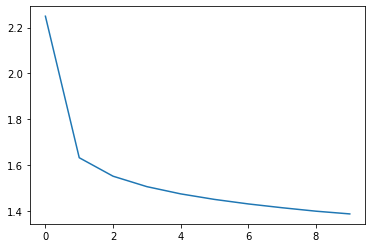

In [ ]:
plt.plot(train_loss_results)

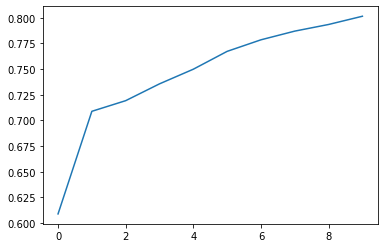

In [ ]:
plt.plot(train_accuracy_results)

## @tf.function decorator
- place this above a function that requires heavy computation
- TensorFlow will make a graph out of this function so that it can execute much quicker (optimizes performance)

In [ ]:
# Note that this cell is just showing syntax - not designed to have actual output
my_model = MyModel(16, 16, 16)
loss = SquaredError()
optimizer = keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

@tf.function ##### 
def get_loss_and_grads(inputs, outputs): # perform forward and backward pass (bulk of computation during training)
  with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs) # forward pass
    grads = tape.gradient(current_loss, my_model.trainable_variables) # backward pass
    return current_loss, grads

for epoch in range(num_epochs):
  for inputs, outputs in training_dataset:
    current_loss, grads = get_loss_and_grads(inputs, outputs)
    optimizer.apply_gradients(zip(grads, my_model.trainable_variables))

TypeError: ignored